In [1]:
import sys
import PyQt5
from PyQt5 import QtGui
from PyQt5.QtWidgets import  QApplication, QWidget, QPushButton, QVBoxLayout, QMessageBox, QLineEdit, QFormLayout,QLabel, QGridLayout, QCheckBox, QSlider
from PyQt5.QtCore import Qt, QTimer
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg
import scipy.stats as stats
from time import time


In [2]:
class CameraSettings:
    Gain=1
    Exposure=500
    EMCCD=False


class FieldSettings:
    XMin=-5
    XMax=5
    XStep=0.05

    YMin=-5
    YMax=5
    YStep=0.05

    ZMin=3.5
    ZMax=4.2
    ZStep=0.001
    
    XInit=1
    YInit=1
    ZInit=3.7
    
    ZSweepMin=3.7
    ZSweepMax=4.1
    ZSweepSteps=40

class History:
    X=[]
    Y=[]
    Z=[]
    Intensity=[]
    Kurtosis=[]
    Time=[]

In [3]:
'''Move the stage'''

class MicroGui:

 
    #Hooks to hardware:
    
    def SetStage(self,X,Y,Z):
        print("move placeholder "+ str(X) +" " + str(Y)+" " +str(Z))

    def GetImage(self):
        return np.random.rand(100,100)

    

    #Internal variables

    His= History()
    CS = CameraSettings()
    FS = FieldSettings()
    
    AmZSweeping=False
    AmStreaming=False
    
    CurrentImage=[0]
    
    def ClearZHistory(self):
        self.His.Z=[]
        self.His.Intensity=[]
        self.His.Kurtosis=[]
        self.His.Time=[]

   
        
    #QT Widget functions 
    def on_stream_click(self):
        if(self.AmStreaming==False):
            self.AmStreaming=True
            self.Stream.setText("Stop Stream")
            self.timer.start(self.CS.Exposure*1.5)
        else:
            self.Stream.setText("Stream")
            self.AmStreaming=False
            self.timer.stop()
        
    def on_one_click(self):
        self.timer.stop()
        self.SnapCameraImg()

    def on_slider_move(self):
        self.MoveTo(self.FS.XMin+self.XSlide.value()*self.FS.XStep,
                    self.FS.YMin+self.YSlide.value()*self.FS.YStep,
                    self.FS.ZMin+self.ZSlide.value()*self.FS.ZStep)
        
    def on_textbox_edit(self):
        self.MoveTo(float(self.XText.text()),
                    float(self.YText.text()),
                    float(self.ZText.text()))
        
    def on_zsweep_click(self):
        if(self.AmZSweeping==False):
            self.MoveTo(self.X,self.Y,float(self.ZSweepMin.text()))
            self.NextStageAction=self.ZSweepStageAction
            self.ZSweep.setText("Stop ZSweep")
            self.AmZSweeping=True
        else:
            self.NextStageAction=self.NullStageAction
            self.ZSweep.setText("ZSweep")
            self.AmZSweeping=False
        
    def on_cam_settings_change(self):
        self.CS.EMCCD=self.CamEMCCD.isChecked()
        #try:    
        if(self.CS.EMCCD==True):
            if(int(self.CamExposure.text())<27):
                self.CS.Exposure=27
            elif(int(self.CamExposure.text())>10000):
                self.CS.Exposure=10000
            else:
                try:
                    self.CS.Exposure=int(self.CamExposure.text())
                except:
                    self.CS.Exposure=500
        elif(self.CS.EMCCD==False):
            if(int(self.CamExposure.text())<500):
                self.CS.Exposure=500
            elif(int(self.CamExposure.text())>10000):
                self.CS.Exposure=10000
            else:
                self.CS.Exposure=int(self.CamExposure.text())
       # except:
        #    self.CS.Exposure=500
            
        #try:
        if(self.CS.EMCCD==False):
            self.CS.Gain=1
        else:
            if(int(self.CamGain.text())<1):
                self.CS.Gain=1
            elif(int(self.CamGain.text())>255):
                self.CS.Gain=255
            else:
                self.CS.Gain=int(self.CamGain.text())     
        #except:
        #    self.CS.Gain=1
            
        self.CamExposure.setText(str(self.CS.Exposure))
        self.CamGain.setText(str(self.CS.Gain))
        
        print("Camera set to (gain/exp): "+ str(self.CS.Gain)+ " " + str(self.CS.Exposure))
    
    def on_handout_change(self):
        if(self.ServosCheckBox.isChecked()==True):
            print("handing out slide for changeover")
        elif(self.ServosCheckBox.isChecked()==False):
            print("returning slide from changeover")
            
    def on_autointensity(self):
        self.MoveTo(self.X,self.Y,self.ZBestIntensity)
        
    def on_autokurtosis(self):
        self.MoveTo(self.X,self.Y,self.ZBestKurtosis)
        
    def on_sequence_go(self):
        if(self.Sequence.text()=="Go"):
            if(self.AmStreaming==False):
                self.on_stream_click()
            self.ImagesToSave=int(self.StoreCount.text())
            self.NextCameraAction=self.SequenceCameraAction
            self.Sequence.setText("Stop")
        else:
            self.StoreCount.setText(str(self.ImagesToSave))
            self.NextCameraAction=self.NullCameraAction
            self.Sequence.setText("Go")
    
    def NullCameraAction(self):
        return
    
    def SequenceCameraAction(self):
        ImageID=int(self.StoreCount.text())
        if(ImageID>1):
            self.StoreCount.setText(str(ImageID-1))
            np.savetxt(self.StorePath.text()+"/im_" +str(self.ImagesToSave-ImageID)+".png", self.CurrentImage)
        else:
            self.NextCameraAction=self.NullCameraAction
            self.Sequence.setText("Go")
            
    def NullStageAction(self):
        return
    
    def ZSweepStageAction(self):
        if(self.Z<self.FS.ZSweepMax):
            self.MoveTo(self.X,self.Y,self.Z+(self.FS.ZSweepMax-self.FS.ZSweepMin)/self.FS.ZSweepSteps)
        else:
            NextStageAction=self.NullStageAction
            self.AmZSweeping=False
            self.ZSweep.setText("ZSweep")
                
    def MoveTo(self, X,Y,Z):
        self.X=round(X,4)
        self.Y=round(Y,4)
        self.Z=round(Z,4)
        self.UpdateAll()
        
    def UpdateAll(self):   
        self.XText.setText(str(self.X))
        self.YText.setText(str(self.Y))
        self.ZText.setText(str(self.Z))
        
        self.XIs.setText(str(self.X))
        self.YIs.setText(str(self.Y))
        self.ZIs.setText(str(self.Z))
        self.XText.setText(str(self.X))
        self.YText.setText(str(self.Y))
        self.ZText.setText(str(self.Z))
        self.XSlide.setValue(int((self.X-self.FS.XMin)/self.FS.XStep))
        self.YSlide.setValue(int((self.Y-self.FS.YMin)/self.FS.YStep))
        self.ZSlide.setValue(int((self.Z-self.FS.ZMin)/self.FS.ZStep))
        
        self.SetStage(self.X,self.Y,self.Z)
        
        if((self.X!=self.His.X[-1]) or (self.Y!=self.His.Y[-1])):
            self.His.X.append(self.X)
            self.His.Y.append(self.Y)
            if(len(self.His.Z)>0):
                self.ClearZHistory()
        
    def MakePosPlots(self):
        self.ax_xy.clear()
        self.ax_z[0].clear()
        self.ax_z[1].clear()


        self.ax_xy.plot([self.X],[self.Y],'o',color='red')
        self.ax_xy.set_xlim(self.FS.XMin,self.FS.XMax)
        self.ax_xy.set_ylim(self.FS.YMin,self.FS.YMax)
        self.ax_z[0].set_xlim(self.FS.ZMin,self.FS.ZMax)
        self.ax_z[1].set_xlim(self.FS.ZMin,self.FS.ZMax)
        self.ax_z[0].set_yticks([])
        self.ax_z[1].set_yticks([])
        self.ax_z[0].set_ylabel("Intensity")
        self.ax_z[1].set_ylabel("Kurtosis")

       
        
        if(len(self.His.X)>0):
            self.ax_xy.plot(self.His.X,self.His.Y,color='dimgrey',alpha=0.1)
    
        if(len(self.His.Z)>0):
            self.ax_z[0].plot(self.His.Z,self.His.Intensity,'.',color='DarkGreen')
            self.ax_z[1].plot(self.His.Z,self.His.Kurtosis,'.',color='DarkBlue')
            TopIntensity=np.max(self.His.Intensity)
            TopKurtosis=np.max(self.His.Kurtosis)

            BottomIntensity=np.min(self.His.Intensity)
            BottomKurtosis=np.min(self.His.Kurtosis)


            self.ax_z[0].plot([self.ZBestIntensity,self.ZBestIntensity],[BottomIntensity,TopIntensity],':',color='pink',linewidth=1)
            self.ax_z[1].plot([self.ZBestKurtosis,self.ZBestKurtosis],[BottomKurtosis,TopKurtosis],'--',color='pink',linewidth=1)
            self.ax_z[0].plot([self.Z,self.Z],[BottomIntensity,TopIntensity],color='DarkRed',linewidth=2)
            self.ax_z[1].plot([self.Z,self.Z],[BottomKurtosis,TopKurtosis],color='DarkRed',linewidth=2)

            self.ax_z[0].set_ylim(BottomIntensity,TopIntensity)
            self.ax_z[1].set_ylim(BottomKurtosis,TopKurtosis)  

        
        self.CanvasObj.draw()
        self.CanvasObj2.draw()

    def MakePhoto(self):
        self.ax_photo.clear()
        self.ax_photo.imshow(self.CurrentImage)
        self.ax_photo.set_xticks([])
        self.ax_photo.set_yticks([])
        self.CanvasPhoto.draw()

        
    def SnapCameraImg(self):
        self.LastSnapTime=time()
        self.His.Z.append(self.Z)
        self.His.Time.append(self.LastSnapTime)
        
        self.CurrentImage=self.GetImage()
        
        self.His.Intensity.append(sum(sum(self.CurrentImage)))
        self.His.Kurtosis.append(stats.kurtosis(np.ndarray.flatten(self.CurrentImage)))  
        self.ZBestIntensity=self.His.Z[np.argmax(self.His.Intensity)]
        self.ZBestKurtosis=self.His.Z[np.argmax(self.His.Kurtosis)]
    
        self.MakePosPlots()
        
        self.MakePhoto()
        
        self.NextStageAction()
        self.NextCameraAction()

        
    #GUI setups

    def SetupMoveFrame(self):
        self.MoveLayout = QGridLayout()

        self.XSlide=QSlider(orientation=Qt.Horizontal)
        self.XSlide.setRange(0, int((self.FS.XMax-self.FS.XMin)/self.FS.XStep))
        self.YSlide=QSlider(orientation=Qt.Horizontal)
        self.YSlide.setRange(0, int((self.FS.YMax-self.FS.YMin)/self.FS.YStep))
        self.ZSlide=QSlider(orientation=Qt.Horizontal)
        self.ZSlide.setRange(0, int((self.FS.ZMax-self.FS.ZMin)/self.FS.ZStep))
        
        self.XText=QLineEdit(text=str(self.FS.XInit))
        self.XText.editingFinished.connect(self.on_textbox_edit)
        self.YText=QLineEdit(text=str(self.FS.YInit))
        self.YText.editingFinished.connect(self.on_textbox_edit)
        self.ZText=QLineEdit(text=str(self.FS.ZInit))
        self.ZText.editingFinished.connect(self.on_textbox_edit)

        self.XIs=QLabel()
        self.YIs=QLabel()
        self.ZIs=QLabel()
        
        self.MoveTo(self.FS.XInit,
                  self.FS.YInit,
                  self.FS.ZInit)
        
        self.MoveLayout.addWidget(QLabel("Stage Control:"),1,0,1,3)
        self.MoveLayout.addWidget(QLabel("X"),2,0,1,1)
        self.MoveLayout.addWidget(self.XText,2,1,1,1)
        self.MoveLayout.addWidget(self.XIs,2,2,1,1)
        self.MoveLayout.addWidget(self.XSlide, 3,1,1,3)
        self.MoveLayout.addWidget(QLabel("Y"),4,0,1,1)
        self.MoveLayout.addWidget(self.YText,4,1,1,1)
        self.MoveLayout.addWidget(self.YIs,4,2,1,1)
        self.MoveLayout.addWidget(self.YSlide, 5,1,1,3)
        self.MoveLayout.addWidget(QLabel("Z"),6,0,1,1)
        self.MoveLayout.addWidget(self.ZText,6,1,1,1)
        self.MoveLayout.addWidget(self.ZIs,6,2,1,1)
        self.MoveLayout.addWidget(self.ZSlide,7,1,1,3)

        self.XSlide.sliderMoved.connect(self.on_slider_move)
        self.YSlide.sliderMoved.connect(self.on_slider_move)
        self.ZSlide.sliderMoved.connect(self.on_slider_move)     
        
    def SetupCamSettingsFrame(self):
        self.CamLayout= QFormLayout()
        self.CamLayout.addRow(QLabel("Camera Settings:"),QLabel(" "))
        self.CamGain=QLineEdit(text=str(self.CS.Gain))
        self.CamExposure=QLineEdit(text=str(self.CS.Exposure))
        self.CamEMCCD=QCheckBox("EMCCD")

        self.CamLayout.addRow(QLabel("Gain:"),self.CamGain)
        self.CamLayout.addRow(QLabel("Exposure:"),self.CamExposure)
        self.CamLayout.addWidget(self.CamEMCCD)

        self.CamGain.editingFinished.connect(self.on_cam_settings_change)
        self.CamExposure.editingFinished.connect(self.on_cam_settings_change)
        self.CamEMCCD.stateChanged.connect(self.on_cam_settings_change)
           
        
    def SetupActionsFrame(self):
        self.ActionsLayout= QGridLayout()
        self.ActionsLayout.addWidget(QLabel("Actions:"),1,0,1,3)
        
        
        self.ZSweep=QPushButton('ZSweep')
        self.ZSweep.clicked.connect(self.on_zsweep_click)
        self.ZSweepMin=QLineEdit(text=str(self.FS.ZSweepMin))
        self.ZSweepMax=QLineEdit(text=str(self.FS.ZSweepMax))
        self.ZSweepSteps=QLineEdit(text=str(self.FS.ZSweepSteps))
        
        self.ServosCheckBox=QCheckBox("Hand out:")
        self.ServosCheckBox.stateChanged.connect(self.on_handout_change)
        
        self.AutoFocusKurtosis=QPushButton("Kurtosis")
        self.AutoFocusIntensity=QPushButton("Intensity")
        self.AutoFocusKurtosis.clicked.connect(self.on_autokurtosis)
        self.AutoFocusIntensity.clicked.connect(self.on_autointensity)

        self.ActionsLayout.addWidget(self.ServosCheckBox,2,0,1,3)
        
        self.ActionsLayout.addWidget(self.ZSweep,3,0,1,3)
        self.ActionsLayout.addWidget(self.ZSweepMin,4,0,1,1)
        self.ActionsLayout.addWidget(self.ZSweepMax,4,1,1,1)
        self.ActionsLayout.addWidget(self.ZSweepSteps,4,2,1,1)
        
        self.ActionsLayout.addWidget(QLabel("AutoFocus:"),5,0,1,1)
        self.ActionsLayout.addWidget(self.AutoFocusIntensity,5,1,1,1)
        self.ActionsLayout.addWidget(self.AutoFocusKurtosis,5,2,1,1)
        

    def SetupCanvasFrame(self):
        self.FigLayout=QVBoxLayout()
        self.fig= plt.figure(figsize=(5,5),dpi=150)
        self.fig.add_axes(rect=[0,0,1,1])
        self.fig2= plt.figure(figsize=(5,5),dpi=150)
        self.fig2.add_axes(rect=[0,0,1,1])

        self.ax_xy=self.fig.get_axes()[0]
        gs = self.fig2.add_gridspec(2, hspace=0)
        self.ax_z = gs.subplots(sharex=True, sharey=False)
        
        self.CanvasObj=FigureCanvasQTAgg(self.fig)
        self.CanvasObj2=FigureCanvasQTAgg(self.fig2)
        self.MakePosPlots()

        self.FigLayout.addWidget(self.CanvasObj)
        self.FigLayout.addWidget(self.CanvasObj2)
        
    def SetupPhotoFrame(self):
        self.PhotoLayout=QGridLayout()
        
    
        self.photo= plt.figure(figsize=(5,5),dpi=200)
        self.photo.add_axes(rect=[0,0,1,1])
        self.ax_photo=self.photo.get_axes()[0]
        self.CanvasPhoto=FigureCanvasQTAgg(self.photo)
        self.PhotoLayout.addWidget(self.CanvasPhoto,1,0,8,4)
        
        self.Stream=QPushButton('Stream')
        self.Stream.clicked.connect(self.on_stream_click)        
        
        self.One=QPushButton('One')
        self.One.clicked.connect(self.on_one_click)        

        self.StoreCount=QLineEdit("100")
        self.StorePath=QLineEdit("./imgs/")
        self.Sequence=QPushButton("Go")
        
        self.Sequence.clicked.connect(self.on_sequence_go)
        
        self.timer=QTimer()
        self.timer.timeout.connect(self.SnapCameraImg)
        
        self.PhotoLayout.addWidget(self.Stream,9,0,1,2)
        self.PhotoLayout.addWidget(self.One,9,2,1,2)
        
        self.PhotoLayout.addWidget(QLabel("Record sequence of:"),10,0,1,1)
        self.PhotoLayout.addWidget(self.StoreCount,11,0,1,1)
        self.PhotoLayout.addWidget(QLabel("into "),11,1,1,1)
        self.PhotoLayout.addWidget(self.StorePath,11,2,1,1)
        self.PhotoLayout.addWidget(self.Sequence,11,3,1,1)
        
    def __init__(self):

        self.LastSnapTime=time()
        self.His.X=[self.FS.XInit]
        self.His.Y=[self.FS.YInit]
        
        self.app = QApplication([])
        self.window = QWidget()
        self.layout= QGridLayout()

        self.SetupMoveFrame()
        
        self.SetupCamSettingsFrame()

        self.SetupCanvasFrame()

        self.SetupActionsFrame()
        
        self.SetupPhotoFrame()
    
        self.layout.addLayout(self.MoveLayout,1,0)
        self.layout.addLayout(self.CamLayout,2,0)
        self.layout.addLayout(self.FigLayout,1,1,3,1)
        self.layout.addLayout(self.ActionsLayout,3,0)
        self.layout.addLayout(self.PhotoLayout,1,2,3,1)
        
        
        self.NextStageAction  = self.NullStageAction
        self.NextCameraAction = self.NullCameraAction
        
        self.window.setLayout(self.layout)
        self.window.show()
        self.app.exec()


move placeholder 1 1 3.7


/var/folders/0l/sqknt5xn1w3dx48zsbjg_7800000gn/T/ipykernel_22896/2575210332.py:40: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  self.timer.start(self.CS.Exposure*1.5)
/var/folders/0l/sqknt5xn1w3dx48zsbjg_7800000gn/T/ipykernel_22896/2575210332.py:224: UserWarning: Attempting to set identical bottom == top == 4968.611901820459 results in singular transformations; automatically expanding.
  self.ax_z[0].set_ylim(BottomIntensity,TopIntensity)
/var/folders/0l/sqknt5xn1w3dx48zsbjg_7800000gn/T/ipykernel_22896/2575210332.py:225: UserWarning: Attempting to set identical bottom == top == -1.2047456010560602 results in singular transformations; automatically expanding.
  self.ax_z[1].set_ylim(BottomKurtosis,TopKurtosis)


move placeholder 1.0 1.0 3.7
move placeholder 1.0 1.5 3.7


/var/folders/0l/sqknt5xn1w3dx48zsbjg_7800000gn/T/ipykernel_22896/2575210332.py:224: UserWarning: Attempting to set identical bottom == top == 5084.399033543003 results in singular transformations; automatically expanding.
  self.ax_z[0].set_ylim(BottomIntensity,TopIntensity)
/var/folders/0l/sqknt5xn1w3dx48zsbjg_7800000gn/T/ipykernel_22896/2575210332.py:225: UserWarning: Attempting to set identical bottom == top == -1.1842378383927608 results in singular transformations; automatically expanding.
  self.ax_z[1].set_ylim(BottomKurtosis,TopKurtosis)


move placeholder 1.0 1.5 3.7
move placeholder 1.9 1.5 3.7


/var/folders/0l/sqknt5xn1w3dx48zsbjg_7800000gn/T/ipykernel_22896/2575210332.py:224: UserWarning: Attempting to set identical bottom == top == 5011.74431125106 results in singular transformations; automatically expanding.
  self.ax_z[0].set_ylim(BottomIntensity,TopIntensity)
/var/folders/0l/sqknt5xn1w3dx48zsbjg_7800000gn/T/ipykernel_22896/2575210332.py:225: UserWarning: Attempting to set identical bottom == top == -1.2042268441712365 results in singular transformations; automatically expanding.
  self.ax_z[1].set_ylim(BottomKurtosis,TopKurtosis)


move placeholder 1.9 1.5 3.7


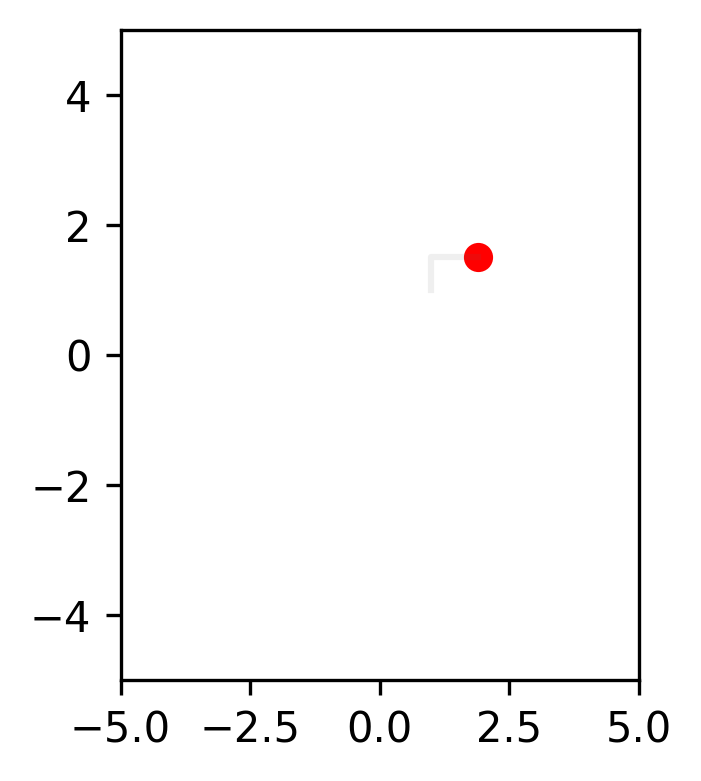

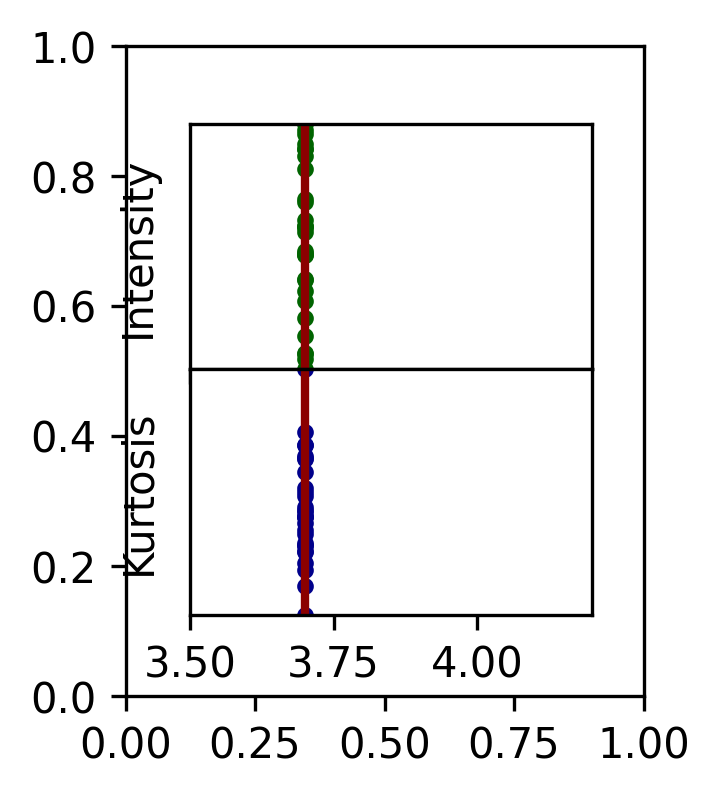

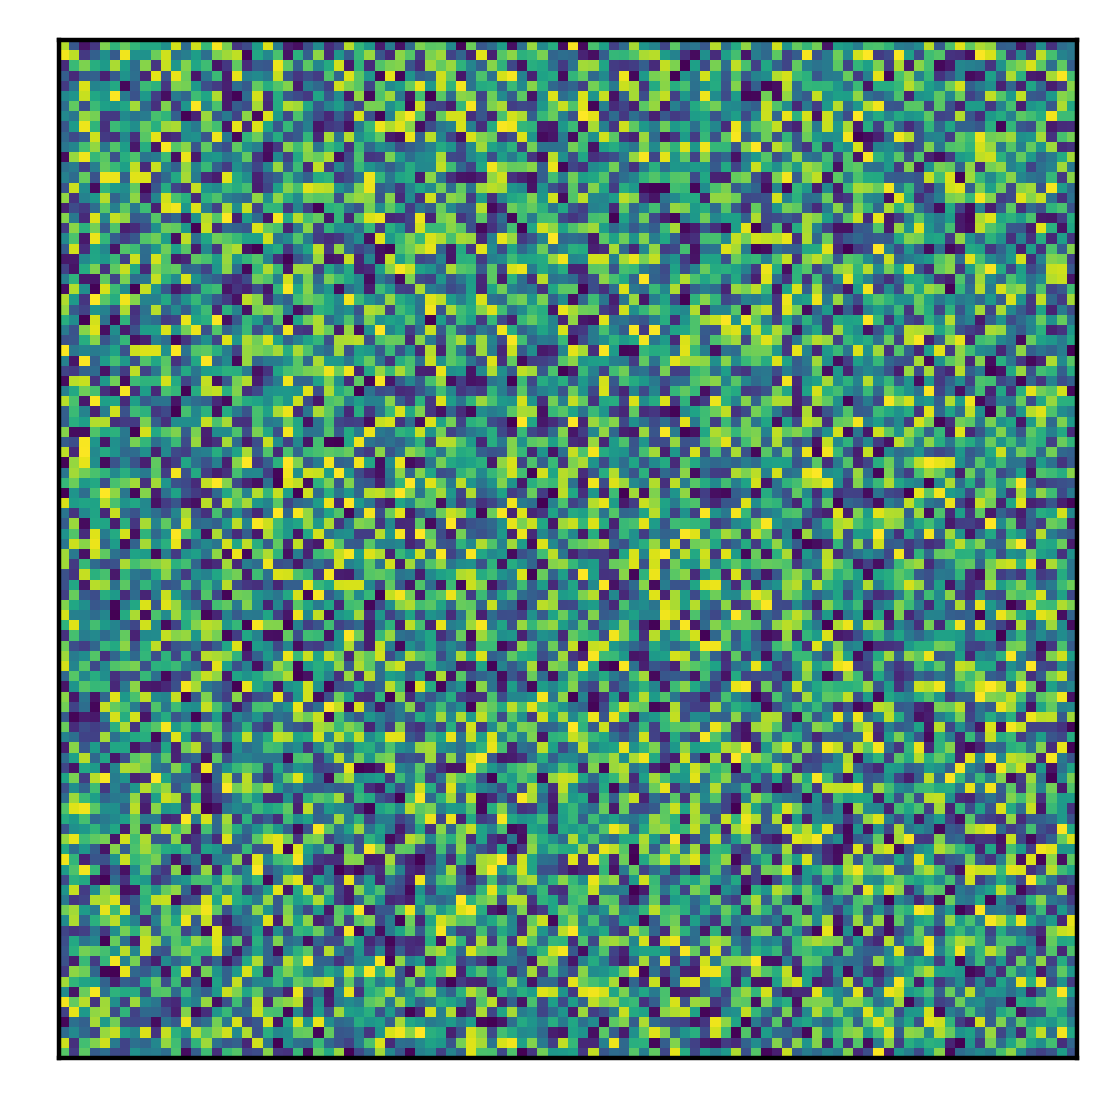

In [4]:
MicroGui()

In [5]:
PyQt5.QtWidgets.Ho

AttributeError: module 'PyQt5.QtWidgets' has no attribute 'Ho'

In [ ]:
fig=plt.figure()

In [ ]:
fig.add_axes()?

In [ ]:
QCheckBox()?
